In [1]:
import numpy as np
import os
from functools import partial
from bmtk.builder import NetworkBuilder
from bmtk.utils.sim_setup import build_env_bionet
import synapses
from bmtool import connectors
from bmtool.connectors import (
    spherical_dist, cylindrical_dist_z, GaussianDropoff, UniformInRange,
    ReciprocalConnector, NormalizedReciprocalRate, UnidirectionConnector,
    OneToOneSequentialConnector, GapJunction,
    syn_dist_delay_feng_section_PN, syn_dist_delay_feng, syn_section_PN, syn_uniform_delay_section, CorrelatedGapJunction
)
from homogenousRules import homo_edge_probability_from_convergence
from build_input import assign_assembly

In [5]:
num_PN = 40
num_PN = np.cumsum(num_PN)
assy_ids = np.empty(num_PN[-1], dtype=int)
n_assemblies = 3
for i, idx in enumerate(assign_assembly(num_PN[-1], n_assemblies)):
    assy_ids[idx] = i
assy_ids = np.split(assy_ids, num_PN[:-1])
display(assy_ids[1])

IndexError: list index out of range

In [2]:
randseed = 1234
rng = np.random.default_rng(randseed)
connectors.rng = rng

network_dir = 'network'
t_sim = 31000.0  # ms
dt = 0.1  # ms

# Network size and dimensions
num_cells = 1000  # 10000 3000 is roughly only many cells are in 400x200
column_width, column_height = 600., 250.
x_start, x_end = - column_width / 2, column_width / 2
y_start, y_end = - column_width / 2, column_width / 2
z_start, z_end = - column_height / 2, column_height / 2

# Distance constraint for all cells
min_conn_dist = 16.0  # um. ~ PN soma diameter
max_conn_dist = 300  # or np.inf

# When enabled, a shell of virtual cells will be created around the core cells.
edge_effects = False

##############################################################################
####################### Cell Proportions and Positions #######################

def num_prop(ratio, N):
    """Calculate numbers of total N in proportion to ratio"""
    ratio = np.asarray(ratio)
    p = np.cumsum(np.insert(ratio.ravel(), 0, 0))  # cumulative proportion
    return np.diff(np.round(N / p[-1] * p).astype(int)).reshape(ratio.shape)


# Number of cells in each population.
# Following 87/13 E/I with 9% PV and 4% SOM from Dura-Bernal el al 2023 model paper need real source
num_PN, num_FSI, num_LTS = num_prop([87, 9, 4], num_cells)
print('Cell numbers: ' + ', '.join(f'{c:s}={n:d}' for c, n in
    zip(['PN', 'FSI', 'LTS'], [num_PN, num_FSI, num_LTS])))

Cell numbers: PN=870, FSI=90, LTS=40


In [3]:
# Generate random cell positions
# Use poisson-disc sampling to generate positions with minimum distance limit.
use_poiss_disc = True

# Get positions for cells in the core
def samples_in_core(samples):
    core_idx = (samples[:, 0] >= x_start) & (samples[:, 0] <= x_end) \
        & (samples[:, 1] >= y_start) & (samples[:, 1] <= y_end) \
        & (samples[:, 2] >= z_start) & (samples[:, 2] <= z_end)
    return core_idx, samples[core_idx]

# Generate samples in cube with side_length
side_length = max(column_width, column_height)
if edge_effects:
    # Extend side length by 2 * max_conn_dist
    side_length = max(column_width + 2 * max_conn_dist, column_height)

    # Compute the outer shell range. Extend the edge by max_conn_dist.
    shell_x_start, shell_y_start = np.array((x_start, y_start)) - max_conn_dist
    shell_x_end, shell_y_end = np.array((x_end, y_end)) + max_conn_dist

    # Compute the core and shell volume
    core_volume = (x_end - x_start) * (y_end - y_start) * column_height
    shell_volume = (shell_x_end - shell_x_start) * \
        (shell_y_end - shell_y_start) * column_height - core_volume

    # Determine the number of shell cells with the same density
    virt_num_cells = int(round(num_cells * shell_volume / core_volume))


    # Get positions for cells in the shell
    def samples_in_shell(samples):
        shell_idx = (samples[:, 0] >= shell_x_start) & (samples[:, 0] <= shell_x_end) \
            & (samples[:, 1] >= shell_y_start) & (samples[:, 1] <= shell_y_end) \
            & (samples[:, 2] >= z_start) & (samples[:, 2] <= z_end)
        return samples[shell_idx]

# Generate samples in cube [0, 1]^3, then scale it to side_length and center it
def scale_cube(samples):
    return side_length * (samples - 0.5)


if use_poiss_disc:
    from scipy.stats import qmc  # qmc.PoissonDisk new in scipy 1.10.0

    ncand = 30  # number of candidates (related to density of points)
    radius = min_conn_dist / side_length
    engine = qmc.PoissonDisk(d=3, radius=radius, ncandidates=ncand, seed=rng)
    samples = scale_cube(engine.fill_space())

    core_idx, pos_list = samples_in_core(samples)
    print(f"Number of positions in core: {len(pos_list):d}")
    print(f"Number of cells in core: {num_cells:d}")
    if len(pos_list) < num_cells:
        raise ValueError("There are not enough position samples generated.")
    if edge_effects:
        shell_pos_list = samples_in_shell(samples[~core_idx])
        print(f"Number of positions in shell: {len(shell_pos_list):d}")
        print(f"Number of cells in shell: {virt_num_cells:d}")
        if len(shell_pos_list) < virt_num_cells:
            raise ValueError("There are not enough position samples generated.")
else:
    cell_dens = num_cells / (column_width * column_width * column_height)
    num_pos = int(cell_dens * side_length ** 3)
    samples = scale_cube(rng.random((num_pos, 3)))
    num_pos = int(0.1 * num_pos)
    while True:
        core_idx, pos_list = samples_in_core(samples)
        add_samples = len(pos_list) < num_cells
        if edge_effects:
            shell_pos_list = samples_in_shell(samples[~core_idx])
            add_samples = add_samples or len(shell_pos_list) < virt_num_cells
        if add_samples:
            new_samples = scale_cube(rng.random((num_pos, 3)))
            samples = np.concatenate((samples, new_samples), axis=0)
        else:
            break

# Draw desired number of samples from the position list
pos_list = rng.choice(pos_list, num_cells, replace=False)

if edge_effects:
    shell_pos_list = rng.choice(shell_pos_list, virt_num_cells, replace=False)

    virt_num_PN, virt_num_FSI, virt_num_LTS = \
        num_prop([num_PN, num_FSI, num_LTS], virt_num_cells)

# TODO: generate random orientations

KeyboardInterrupt: 

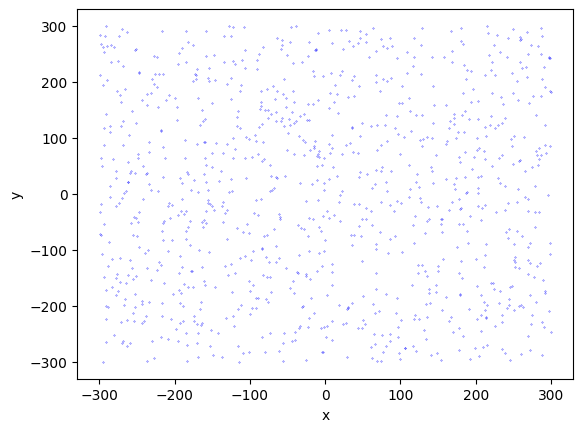

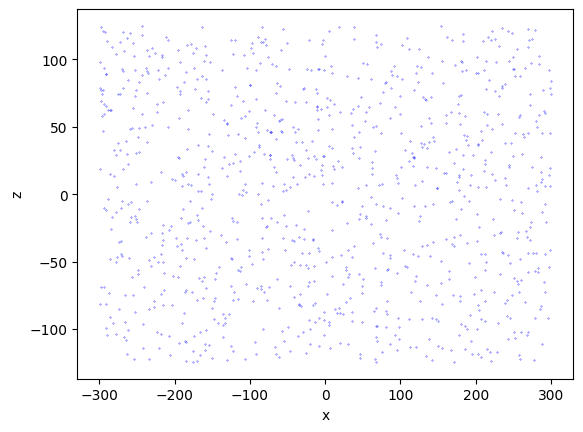

In [ ]:
import matplotlib.pyplot as plt

markersize = 0.5

plt.figure()
plt.plot(pos_list[:, 0], pos_list[:, 1], 'b.', markersize=markersize)
#plt.plot(shell_pos_list[:, 0], shell_pos_list[:, 1], 'r.', markersize=markersize)
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.plot(pos_list[:, 0], pos_list[:, 2], 'b.', markersize=markersize)
#plt.plot(shell_pos_list[:, 0], shell_pos_list[:, 2], 'r.', markersize=markersize)
plt.xlabel('x')
plt.ylabel('z')

plt.show()

In [ ]:
##############################################################################
####################### Functions for Building Network #######################

# Dictionary to store NetworkBuilder objects referenced by name
networks = {}

def build_networks(network_definitions: list) -> dict:
    """
    `network_definitions` should be a list of dictionaries, e.g. [{}, {}, ...]
    Keys should include an arbitrary `network_name`, a positions_list (if any),
    and `cells`. `cells` should contain a list of dictionaries, and each
    dictionary should corrospond with any valid input for BMTK
    NetworkBuilder.add_nodes() method. A dictionary of BMTK NetworkBuilder
    objects will be returned, reference by individual network_name."""
    for net_def in network_definitions:
        network_name = net_def['network_name']
        if networks.get(network_name) is None:
            networks[network_name] = NetworkBuilder(network_name)
        pos_list = net_def.get('positions_list')

        # Add cells to the network
        num = 0
        for cell in net_def['cells']:
            num_cells = cell['N']
            extra_kwargs = {}
            if pos_list is not None:
                extra_kwargs['positions'] = pos_list[num:num + num_cells]
                num += num_cells

            cell = {k: v for k, v in cell.items() if v is not None}
            extra_kwargs = {k: v for k, v in extra_kwargs.items()
                            if v is not None}
            networks[network_name].add_nodes(**cell, **extra_kwargs)

    return networks


def build_edges(networks, edge_definitions, edge_params,
                edge_add_properties, syn):
    """
    Builds the edges for each network given a set of 'edge_definitions',
    examples shown later in the code
    """
    for edge in edge_definitions:
        network_name = edge['network']
        net = networks[network_name]
        # edge arguments
        print("Adding edge: " + edge['param'])
        edge_params_val = edge_params[edge['param']].copy()
        # get synapse template file
        dynamics_file = edge_params_val.get('dynamics_params')
        model_template = syn[dynamics_file]['level_of_detail']
        # get source and target nodes
        edge_src_trg = edge.get('edge')
        if edge_src_trg:
            edge_src_trg = edge_src_trg.copy()
            src_net = edge_src_trg.pop('source_network', network_name)
            trg_net = edge_src_trg.pop('target_network', network_name)
            source = networks[src_net].nodes(**edge_src_trg.get('source', {}))
            target = networks[trg_net].nodes(**edge_src_trg.get('target', {}))
            edge_params_val.update({'source': source, 'target': target})
        # use connector class
        connector_class = edge_params_val.pop('connector_class', None)
        if connector_class is not None:
            # create a connector object
            connector_params = edge_params_val.pop('connector_params', {})
            connector = connector_class(**connector_params)
            # keep object reference in the dictionary
            edge_params[edge['param']]['connector_object'] = connector
            if edge_src_trg:
                connector.setup_nodes(source=source, target=target)
            edge_params_val.update(connector.edge_params())
        conn = net.add_edges(model_template=model_template, **edge_params_val)

        edge_properties = edge.get('add_properties')
        if edge_properties:
            edge_properties_val = edge_add_properties[edge_properties].copy()
            if connector_class is not None:
                # pass connector object to the rule for edge properties
                edge_properties_val['rule'] = partial(
                    edge_properties_val['rule'], connector=connector)
            conn.add_properties(**edge_properties_val)


def get_connector(param):
    """Get connector object stored in edge_params"""
    edge_params_val = edge_params[param]
    if 'connector_object' in edge_params_val:
        return edge_params_val['connector_object']
    else:
        raise ValueError("No connector used in '%s'" % param)


def save_networks(networks, network_dir):
    """Build and save network"""
    # Remove the existing network_dir directory
    if os.path.isdir(network_dir):
        for f in os.listdir(network_dir):
            os.remove(os.path.join(network_dir, f))

    # Run through each network and save their nodes/edges
    for network_name, network in networks.items():
        print('Building ' + network_name)
        network.build()
        network.save_nodes(output_dir=network_dir)
        network.save_edges(output_dir=network_dir)


In [ ]:
##############################################################################
############################ Network Definitions #############################

network_definitions = [
    {   # Start Layer 2/3
        'network_name': 'cortex',
        'positions_list': pos_list,
        'cells': [
            {   # CP
                'N': num_PN,
                'pop_name': 'PN',
                'rotation_angle_zaxis': None,
                'rotation_angle_yaxis': None,
                'model_type': 'biophysical',
                'model_template': 'hoc:CP_Cell',
                'morphology': 'blank.swc'
            },
            {   # FSI
                'N': num_FSI,
                'pop_name': 'FSI',
                'rotation_angle_zaxis': None,
                'rotation_angle_yaxis': None,
                'model_type': 'biophysical',
                'model_template': 'hoc:FSI_Cell',
                'morphology': 'blank.swc'
            },
            {   # LTS
                'N': num_LTS,
                'pop_name': 'LTS',
                'rotation_angle_zaxis': None,
                'rotation_angle_yaxis': None,
                'model_type': 'biophysical',
                'model_template': 'hoc:LTS_Cell',
                'morphology': 'blank.swc'
            }
        ]
    },  # End Layer 2/3
    {   # Extrinsic Thalamic Inputs
        'network_name': 'thalamus',
        'positions_list': None,
        'cells': [
            {   # Virtual Cells
                'N': num_PN,
                'pop_name': 'thal',
                'potential': 'exc',
                'model_type': 'virtual'
            }
        ]
    },
    {   # Extrinsic Baseline Inputs
        'network_name': 'baseline',
        'positions_list': None,
        'cells': [
            {   # Virtual Cells
                'N': num_cells,
                'pop_name': 'base',
                'potential': 'exc',
                'model_type': 'virtual'
            }
        ]
    }
]


##############################################################################
################################ EDGE EFFECTS ################################

if edge_effects:
    # This network should contain all the same properties as the original
    # network, except the cell should be virtual. For connectivity, you should
    # name the cells the same as the original network because connection rules
    # defined later will require it
    shell_network = [
        {   # Start Layer 5
            'network_name': 'shell',
            'positions_list': shell_pos_list,
            'cells': [
                {   # CP
                    'N': virt_num_PN,
                    'pop_name': 'CP',
                    'model_type': 'virtual'
                },
                {   # FSI
                    'N': virt_num_FSI,
                    'pop_name': 'FSI',
                    'model_type': 'virtual'
                },
                {   # LTS
                    'N': virt_num_LTS,
                    'pop_name': 'LTS',
                    'model_type': 'virtual'
                }
            ]
        }  # End Layer 5
    ]

    # Add the shell to our network definitions
    network_definitions.extend(shell_network)

############################## END EDGE EFFECTS ##############################
##############################################################################

# Build and save our NetworkBuilder dictionary
networks = build_networks(network_definitions)


##########################################################################
#############################  BUILD EDGES  ##############################

# Whole reason for restructuring network building lies here, by separating out
# the source and target params from the remaining parameters in
# NetworkBuilder.add_edges() function we can reuse connectivity rules for the
# virtual shell or elsewhere
# [
#  {
#   'network': 'network_name',  # Name of the network to which edges are added
#   'edge': {
#       'source': {},  # dictionary of properties of desired population
#       'target': {},
#       'source_network': 'network_name1'  # network name for the population
#       'target_network': 'network_name2'  # if different from network_name
#       },  # source and target are required
#       # source_network and target_network are optional
#   'param': 'name_of_edge_parameters',  # to be coupled with when add_edges()
#   'add_properties': 'prop_name'  # name of edge_add_properties for additional
#       # connection properties, like delay
#   }
# ]

edge_definitions = [
    {   # CP -> CP Reciprocal
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['PN']},
            'target': {'pop_name': ['PN']}
        },
        'param': 'PN2PN',
        'add_properties': 'syn_dist_delay_feng_section_PN'
    },
    {   # FSI -> FSI Reciprocal
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['FSI']},
            'target': {'pop_name': ['FSI']}
        },
        'param': 'FSI2FSI',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # LTS -> LTS Unidirectional
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['LTS']},
            'target': {'pop_name': ['LTS']}
        },
        'param': 'LTS2LTS',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # FSI -> LTS forward
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['FSI']},
            'target': {'pop_name': ['LTS']}
        },
        'param': 'FSI2LTS',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # FSI <- LTS backward
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['LTS']},
            'target': {'pop_name': ['FSI']}
        },
        'param': 'LTS2FSI',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # CP -> FSI forward
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['PN']},
            'target': {'pop_name': ['FSI']}
        },
        'param': 'PN2FSI',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # CP <- FSI backward
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['FSI']},
            'target': {'pop_name': ['PN']}
        },
        'param': 'FSI2PN',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # CP -> LTS forward
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['PN']},
            'target': {'pop_name': ['LTS']}
        },
        'param': 'PN2LTS',
        'add_properties': 'syn_dist_delay_feng_default'
    },
    {   # CP <- LTS backward
        'network': 'cortex',
        'edge': {
            'source': {'pop_name': ['LTS']},
            'target': {'pop_name': ['PN']}
        },
        'param': 'LTS2PN',
        'add_properties': 'syn_dist_delay_feng_default'
    },
        ################### THALAMIC INPUT ###################
    {   # Thalamus Excitation to CP
        'network': 'cortex',
        'edge': {
            'source_network': 'thalamus',
            'source': {},
            'target': {'pop_name': ['PN']}
        },
        'param': 'Thal2PN'
    },
        ################### Baseline INPUT ###################
    {   # Excitation to CP
        'network': 'cortex',
        'edge': {
            'source_network': 'baseline',
            'source': {},
            'target': {'pop_name': ['PN']}
        },
        'param': 'Base2PN'
    },
    {   # Excitation to FSI
        'network': 'cortex',
        'edge': {
            'source_network': 'baseline',
            'source': {},
            'target': {'pop_name': ['FSI']}
        },
        'param': 'Base2FSI'
    },
    {   # Excitation to LTS
        'network': 'cortex',
        'edge': {
            'source_network': 'baseline',
            'source': {},
            'target': {'pop_name': ['LTS']}
        },
        'param': 'Base2LTS'
    }
]

# edge_params should contain additional parameters to be added to add_edges().
# The following parameters for random synapse placement are not necessary in
# edge_params if afferent_section_id and afferent_section_pos are specified.
# distance_range: place synapse within distance range [dmin, dmax] from soma.
# target_sections: place synapse within the given sections in a list.
# afferent_section_id must be specified here even though it will be overwritten
# by add_properties(), since there could be potential error due to the dtype
# being forced to be converted to float if values are not specified in the
# corresponding column in the edge csv file.


@np.vectorize
def PconnPN2PN(d):
    if d > 0 and d <=25:
        return 0.09
    if d > 25 and d <=50:
        return 0.07
    if d > 50 and d <=100:
        return 0.05
    if d > 100 and d <=200:
        return 0.01
    if d > 200: 
        return 0

@np.vectorize
def PconnPN2FSI(d):
    if d > 0 and d <=25:
        return 0.75
    if d > 25 and d <=50:
        return 0.57
    if d > 50 and d <=100:
        return 0.6
    if d > 100: 
        return 0

@np.vectorize
def PconnFSI2PN(d):
    if d > 0 and d <=25:
        return 0.63
    if d > 25 and d <=50:
        return 0.51
    if d > 50 and d <=100:
        return 0.55
    if d > 100: 
        return 0

def NRR_PN2FSI(d): # pr/(p0*p1)
    if d > 0 and d <=25:
        return (0.52/(0.75*0.63))
    if d > 25 and d <=50:
        return (0.3/(0.57*0.51))
    if d > 50 and d <=100:
        return (0.25/(0.6*0.55))
    if d > 100: 
        return 0   



edge_params = {
    'PN2PN': {
        'connector_class': ReciprocalConnector,
        'connector_params': {
            'p0': PconnPN2PN,
            'p0_arg': cylindrical_dist_z,
            #'pr': NormalizedReciprocalRate(NRR=NRR_EE),
            #'pr_arg': '0'
            },
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 1,
        'afferent_section_pos': 0.4,
        'dynamics_params': 'PN2PN.json'
    },
    'FSI2FSI': {
        'connector_class': ReciprocalConnector,
        'connector_params': {
            'p0': GaussianDropoff(
                stdev=126.77, min_dist=min_conn_dist, max_dist=max_conn_dist,
                ptotal=0.103, ptotal_dist_range=(min_conn_dist, 200.),
                dist_type='spherical'),
            'p0_arg': spherical_dist,
            'pr': 0.04,
            'estimate_rho': True,
            'dist_range_forward': (min_conn_dist, 100.)
            # 'rho': pr_2_rho(0.103, 0.103, 0.04)  # use fixed rho instead
            },
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 0,  # soma
        'afferent_section_pos': 0.5,
        'dynamics_params': 'FSI2FSI.json'
    },
    'LTS2LTS': {
        'connector_class': UnidirectionConnector,
        'connector_params': {
            'p': GaussianDropoff(
                stdev=126.77, min_dist=min_conn_dist, max_dist=max_conn_dist,
                ptotal=0.15, ptotal_dist_range=(min_conn_dist, 50.),
                dist_type='spherical'),
            'p_arg': spherical_dist
            },
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 0,  # soma
        'afferent_section_pos': 0.5,
        'dynamics_params': 'LTS2LTS.json'
    },
    'FSI2LTS': {
        'connector_class': ReciprocalConnector,
        'connector_params': {
            'p0': GaussianDropoff(
                stdev=126.77, min_dist=min_conn_dist, max_dist=max_conn_dist,
                ptotal=0.34, ptotal_dist_range=(min_conn_dist, 50.),
                dist_type='spherical'),
            'p0_arg': spherical_dist,
            'p1': GaussianDropoff(
                stdev=126.77, min_dist=min_conn_dist, max_dist=max_conn_dist,
                ptotal=0.53, ptotal_dist_range=(min_conn_dist, 50.),
                dist_type='spherical'),  # 53% unidirectional
            'p1_arg': spherical_dist,
            'pr': 0.22,
            'estimate_rho': True,
            'dist_range_forward': (min_conn_dist, 50.)
            },
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 0,  # soma
        'afferent_section_pos': 0.5,
        'dynamics_params': 'FSI2LTS.json'
    },
    'LTS2FSI': {
        'connector_class': get_connector,
        'connector_params': {'param': 'FSI2LTS'},
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 0,  # soma
        'afferent_section_pos': 0.5,
        'dynamics_params': 'LTS2FSI.json'
    },
    'PN2FSI': {
        'connector_class': ReciprocalConnector,
        'connector_params': {
            'p0': PconnPN2FSI, #from Holmgren et al 2003 
            'p0_arg': cylindrical_dist_z,
            'p1': PconnFSI2PN, # roughly from Holmgren et al 2003 figure 3E
            'symmetric_p1_arg': True,
            'pr': NormalizedReciprocalRate(NRR_PN2FSI),
            'pr_arg': '0'
            },
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 1,  # dend
        'afferent_section_pos': 0.5,
        'dynamics_params': 'PN2FSI.json'
    },
    'FSI2PN': {
        'connector_class': get_connector,
        'connector_params': {'param': 'PN2FSI'},
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 0,  # soma
        'afferent_section_pos': 0.5,
        'dynamics_params': 'FSI2PN.json'
    },
    'PN2LTS': {
        'connector_class': ReciprocalConnector,
        'connector_params': {
            'p0': GaussianDropoff(
                stdev=99.84, min_dist=0., max_dist=max_conn_dist,
                ptotal=0.28, ptotal_dist_range=(0., 100.),
                dist_type='cylindrical'),
            'p0_arg': cylindrical_dist_z,
            'p1': GaussianDropoff(
                stdev=96.60, min_dist=min_conn_dist, max_dist=max_conn_dist,
                ptotal=0.39, ptotal_dist_range=(min_conn_dist, 100.),
                dist_type='spherical'),
            'p1_arg': spherical_dist,
            'pr': 0.16,
            'estimate_rho': True,
            'dist_range_backward': (min_conn_dist, 100.)
            },
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 1,  # dend
        'afferent_section_pos': 0.5,
        'dynamics_params': 'PN2LTS.json'
    },
    'LTS2PN': {
        'connector_class': get_connector,
        'connector_params': {'param': 'PN2LTS'},
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.8,
        'sigma_upper_bound': 3.,
        'afferent_section_id': 2,
        'afferent_section_pos': 0.8,  # end of apic
        'dynamics_params': 'LTS2PN.json'
    },
    'Thal2PN': {
        'connector_class': OneToOneSequentialConnector,
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.3,
        'sigma_upper_bound': 3.,
        'delay': 0.0,
        'afferent_section_id': 2,
        'afferent_section_pos': 0.8,  # end of apic
        'dynamics_params': 'Thal2PN.json'
    },
    'Base2PN': {
        'connector_class': OneToOneSequentialConnector,
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.3,
        'sigma_upper_bound': 3.,
        'delay': 0.0,
        'afferent_section_id': 2,
        'afferent_section_pos': 0.8,  # end of apic
        'dynamics_params': 'Thal2PN.json'
    },
    'Base2FSI': {
        'connector_class': get_connector,
        'connector_params': {'param': 'Base2PN'},
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.6,
        'sigma_upper_bound': 3.,
        'delay': 0.0,
        'afferent_section_id': 1,  # dend
        'afferent_section_pos': 0.5,
        'dynamics_params': 'Base2FSI.json'
    },
    'Base2LTS': {
        'connector_class': get_connector,
        'connector_params': {'param': 'Base2PN'},
        'weight_function': 'lognormal_weight',
        'syn_weight': 1.,
        'weight_sigma': 0.6,
        'sigma_upper_bound': 3.,
        'delay': 0.0,
        'afferent_section_id': 1,  # dend
        'afferent_section_pos': 0.5,
        'dynamics_params': 'Base2LTS.json'
    }
}  # edges referenced by name

# Will be called by conn.add_properties() for the associated connection
edge_add_properties = {
    'syn_dist_delay_feng_section_PN': {
        'names': ['delay', 'afferent_section_id', 'afferent_section_pos'],
        'rule': syn_dist_delay_feng_section_PN,
        'rule_params': {
            'p': 0.9, 'sec_id': (1, 2), 'sec_x': (0.4, 0.6), 'min_delay': 0.8
        },
        'dtypes': [float, np.uint16, float]
    },
    'syn_section_PN': {
        'names': ['afferent_section_id', 'afferent_section_pos'],
        'rule': syn_section_PN,
        'rule_params': {'p': 0.9, 'sec_id': (1, 2), 'sec_x': (0.4, 0.6)},
        'dtypes': [np.uint16, float]
    },
    'syn_dist_delay_feng_default': {
        'names': 'delay',
        'rule': syn_dist_delay_feng,
        'dtypes': float
    },
    'syn_uniform_delay_section': {
        'names': 'delay',
        'rule': syn_uniform_delay_section,
        'rule_params': {'low': 0.8, 'high': 1.2},
        'dtypes': float
    }
}

In [ ]:
# Load synapse dictionaries
# See synapses.py - loads each json's in components/synaptic_models/synapses_STP
# into a dictionary so the properties can be referenced in the files,
# e.g., syn['file.json'].get('property')
syn_dir = 'components/synaptic_models/synapses_STP'
synapses.load()
syn = synapses.syn_params_dicts(syn_dir=syn_dir)

# Build your edges into the networks
build_edges(networks, edge_definitions, edge_params, edge_add_properties, syn)

Adding edge: PN2PN
Adding edge: FSI2FSI
Adding edge: LTS2LTS
Adding edge: FSI2LTS
Adding edge: LTS2FSI
Adding edge: PN2FSI
Adding edge: FSI2PN
Adding edge: PN2LTS
Adding edge: LTS2PN
Adding edge: Thal2PN
All target population partitions are filled.
Adding edge: Base2PN
Adding edge: Base2FSI
Adding edge: Base2LTS
All target population partitions are filled.


In [ ]:
##############################################################################
############################  EDGE EFFECTS EDGES  ############################

if edge_effects:
    # These rules are for edge effect edges. They should mimic the connections
    # created previously but using unidirectional connector.
    # Re-use the connector params set above.

    # Find core network edge types that need shell connections
    core_network_name = 'cortex'
    core_edge_def = []
    for edge in edge_definitions:
        network_name = edge['network']
        if network_name != core_network_name:
            continue
        is_core = True
        edge_src_trg = edge.get('edge')
        if edge_src_trg:
            for net_type in ('source_network', 'target_network'):
                net_name = edge_src_trg.get(net_type)
                if net_name is not None and net_name != core_network_name:
                    is_core = False
        if is_core:
            core_edge_def.append(edge)

    # Automatically set up network edges and parameters for shell network
    # Only connections from shell to core is needed, so UnidirectionConnector
    # is used, and parameters are extracted from connectors used in core edges.
    shell_network_name = 'shell'
    shell_edges = []
    shell_edge_params = {}
    for edge in core_edge_def:
        shell_edge = edge.copy()
        edge_src_trg = shell_edge.get('edge')
        if edge_src_trg:
            edge_src_trg['source_network'] = shell_network_name
        shell_edge['param'] = shell_network_name + shell_edge['param']
        shell_edges.append(shell_edge)

        edge_params_val = edge_params[edge['param']].copy()
        connector = edge_params_val.pop('connector_object', None)
        connector_class = edge_params_val.get('connector_class')
        if (connector_class is not None and
                connector_class is not UnidirectionConnector):
            replace = True
            var_list = ('p', 'p_arg', 'n_syn')
            if connector_class is ReciprocalConnector:
                var_map = ('p0', 'p0_arg', 'n_syn0')
            elif connector_class is get_connector:
                var_map = ('p1', 'p1_arg', 'n_syn1')
            else:
                replace = False
                print("Warning: Connector method not identified. "
                      "Use the same connector class for shell edges.")
            if replace:
                edge_params_val['connector_class'] = UnidirectionConnector
                connector_params = {
                    k: connector.vars[k0] for k, k0 in zip(var_list, var_map)
                    }
                connector_params['verbose'] = connector.verbose
                edge_params_val['connector_params'] = connector_params
        shell_edge_params[shell_edge['param']] = edge_params_val

    # Check parameters
    print("\nShell edges:")
    for shell_edge in shell_edges:
        print(shell_edge)
    print("\nShell edge parameters:")
    for param, edge_params_val in shell_edge_params.items():
        print(param + ':')
        print(edge_params_val)
    print("")

    # Build your shell edges into the networks
    build_edges(networks, shell_edges, shell_edge_params,
                edge_add_properties, syn)

########################## END EDGE EFFECTS ##############################
##########################################################################

In [ ]:
##########################################################################
############################ GAP JUNCTIONS ###############################

net = networks['cortex']

# FSI
g_gap = 0.000066  # microsiemens
# gap junction probability correlated with chemical synapse
gap_junc_FSI = CorrelatedGapJunction(
    p_non=GaussianDropoff(
        mean=min_conn_dist, stdev=98.0,
        min_dist=min_conn_dist, max_dist=max_conn_dist,
        ptotal=0.267, ptotal_dist_range=(min_conn_dist, 200.),
        dist_type='spherical'),
    p_uni=0.56, p_rec=1.,
    connector=edge_params['FSI2FSI']['connector_object']
)
population = net.nodes(pop_name='FSI')
gap_junc_FSI.setup_nodes(source=population, target=population)

conn = net.add_edges(
    is_gap_junction=True, syn_weight=g_gap, target_sections=None,
    afferent_section_id=0, afferent_section_pos=0.5,
    **gap_junc_FSI.edge_params()
)

# LTS
g_gap = 0.00076  # microsiemens
# gap junction probability uncorrelated with chemical synapse
LTS_uncorr_p = GaussianDropoff(
    mean=0., stdev=74.28,
    min_dist=min_conn_dist, max_dist=max_conn_dist,
    ptotal=0.85, ptotal_dist_range=(min_conn_dist, 50.),
    dist_type='spherical'
)
gap_junc_LTS = CorrelatedGapJunction(
    p_non=LTS_uncorr_p, p_uni=LTS_uncorr_p, p_rec=LTS_uncorr_p,
    connector=edge_params['LTS2LTS']['connector_object']
)
population = net.nodes(pop_name='LTS')
gap_junc_LTS.setup_nodes(source=population, target=population)

conn = net.add_edges(
    is_gap_junction=True, syn_weight=g_gap, target_sections=None,
    afferent_section_id=0, afferent_section_pos=0.5,
    **gap_junc_LTS.edge_params()
)

In [ ]:
##########################################################################
###############################  BUILD  ##################################

# Save the network into the appropriate network dir
save_networks(networks, network_dir)

Building cortex

Start building connection between: 
  cortex: pop_name=='['PN']'
  cortex: pop_name=='['PN']'
Output of p0, p0_arg will be cached.
Estimated value of rho=-0.047
Time for estimating rho: 5.819 sec
Total time for creating connection matrix: 7.499 sec
Numbers of (all, reciprocal) connections:
Number of connected pairs: (4660, 14)
Number of possible connections: (97269)
Fraction of connected pairs in possible ones: (4.79%, 0.01%)
Number of total pairs: 378015
Fraction of connected pairs in all pairs: (1.23%, 0.00%)

Assigning forward connections.
Done! 
Time for building connections: 0.137 sec

Start building connection between: 
  cortex: pop_name=='['FSI']'
  cortex: pop_name=='['FSI']'
Output of p0, p0_arg will be cached.
Estimated value of rho=0.071
Time for estimating rho: 0.020 sec
Total time for creating connection matrix: 0.027 sec
Numbers of (all, reciprocal) connections:
Number of connected pairs: (178, 9)
Number of possible connections: (1567)
Fraction of connec

Building baseline


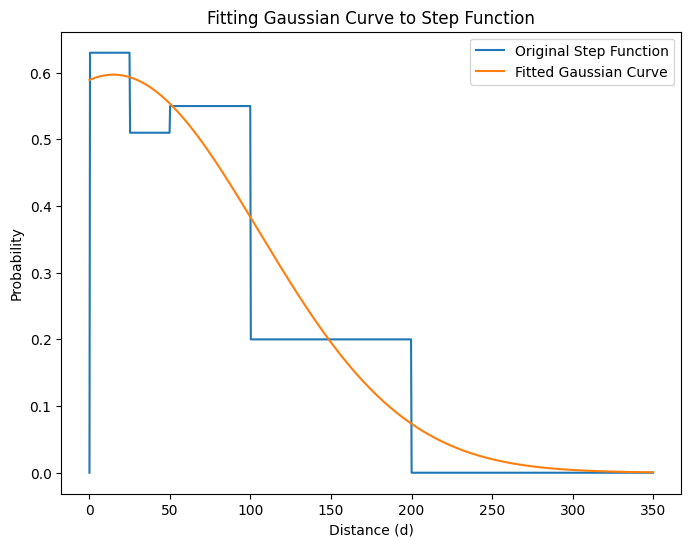

Fitted Amplitude: 0.5970881147949408
Fitted Mean: 14.81444536580773
Fitted Standard Deviation: 90.44348791208947
pmax: 0.5891317465429214


In [10]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the step function
def PconnPN2PN(d):
    if 0 < d <= 25:
        return 0.09
    elif 25 < d <= 50:
        return 0.07
    elif 50 < d <= 100:
        return 0.05
    elif 100 < d <= 300:
        return 0.01
    else:
        return 0.0
    
def PconnPN2FSI(d):
    if d > 0 and d <=25:
        return 0.75
    elif d > 25 and d <=50:
        return 0.57
    elif d > 50 and d <=100:
        return 0.6
    elif d>100 and d<=200:
        return 0.2 # value was guessed to make curve not shit
    else: 
        return 0

def PconnFSI2PN(d):
    if d > 0 and d <=25:
        return 0.63
    elif d > 25 and d <=50:
        return 0.51
    elif d > 50 and d <=100:
        return 0.55
    elif d>100 and d<=200:
        return 0.2 # value was guessed to make curve not shit
    else:
        return 0

# Generate x values for the curve fitting
x_data = np.linspace(0, 350, 1000)  # Adjust range as needed

# Generate y values corresponding to the step function
y_data = np.array([PconnFSI2PN(d) for d in x_data])

# Check for infinite or NaN values in y_data
if np.any(np.isnan(y_data)) or np.any(np.isinf(y_data)):
    print("Error: y_data contains NaN or infinite values.")
else:
    # Define a Gaussian (normal) distribution function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

    # Initial guess for parameters
    initial_guess = [0.1, 100, 50]

    # Fit the Gaussian curve to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)

    # Plot the original step function and the fitted Gaussian curve
    plt.figure(figsize=(8, 6))
    plt.plot(x_data, y_data, label='Original Step Function')
    plt.plot(x_data, gaussian(x_data, *popt), label='Fitted Gaussian Curve')
    plt.xlabel('Distance (d)')
    plt.ylabel('Probability')
    plt.title('Fitting Gaussian Curve to Step Function')
    plt.legend()
    plt.show()

    # Print the fitted parameters
    print("Fitted Amplitude:", popt[0])
    print("Fitted Mean:", popt[1])
    print("Fitted Standard Deviation:", popt[2])
    print("pmax:", gaussian(x_data, *popt)[0])



In [1]:
import re

string = "cortex: pop_name=='['FSI']'"
print(string)

src_match = re.search(r"([^:]+):\s*pop_name=='\['([^']+)'", string)

# Construct the final strings if matches are found
src_pop_name = f"{src_match.group(1)}:{src_match.group(2)}" if src_match else None
print(src_pop_name)


cortex: pop_name=='['FSI']'
cortex:FSI
